Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [18]:
#print(config.project_tmpdir)

In [19]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc", # missing the 2 values from 1989
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc", # missing the 5 values from 1898 and 1990
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
]

obspack_files = {}
station_list = []
for f in obspack_filenames:
    stn = os.path.basename(f).split('_')[1]
    station_list.append(stn)
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 128 Obspack text files (e.g. mlo_surface-flask_1_representative.txt)
- 3 ship track files (e.g. HAM_loc.txt)
- example first three lines (includes 10 requested tracers, plus ACTM and Obs):

\# APO NCAR: expt-2022  # Model Info : MIROC4-ACTM_T42L67

 Year MM DD HH MI IS  DoY    UTC   Obs_Lat  Obs_Lon   Alt(m)       apo_jena   co2_gridfed   co2_oco2mip      co2_cesm    co2_somffn       n2_cesm        n2_era    o2_gridfed       o2_cesm    o2_gk01r16  CO2actm_gc3t        CO2obs
 
 2014  9  6  1  0  0  249    3600    51.50     0.50    10.00      377.2772      520.9326      511.4102      365.0510      378.7311      384.5987      412.1419      231.1653      420.1221      401.9648      418.9030     -999.0000


In [20]:
sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # without derived vars

X_O2 = 0.2094 

#droot = f"{config.project_tmpdir}/simulation-data/MIROC4-ACTM_T42"
droot = "/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/MIROC4-ACTM/selected_obspack"

station_records = {}
for station in station_list:

    path = f"{droot}/{obspack_files[station].replace('.nc', '.txt')[4:]}"
    print(path)
    df = pd.read_csv(path, delim_whitespace=True, header=1, na_values=-599.0000)
    df = df.rename({'Year': 'year', 'MM': 'month', 'DD': 'day', 'HH': 'hour', 'MI': 'minute'}, axis=1)

    # merge into original ObsPack, to allow outputting for other uses
    path = f"{obspack_dir}/{obspack_files[station]}"
    print(path)
    ds = xr.open_dataset(path)
    

    # ALT and LJO are missing 1989 and 1990 obs, need to remove from original ObsPack to match
    ds=ds.where(ds.time_components[:,0]>1990,drop=True)

    #print(df.shape[0])
    #print(ds.dims['obs'])
    assert df.shape[0] == ds.dims['obs']

    for v in sno_vars:
        ds[v]=df[v]


    for v in sno_vars:
        ds[v]=ds[v]-400.0

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    ds['dim_0'] = ds['time']
    ds = ds.drop('time').rename({'dim_0': 'time'})
    
    # convert apo_jena to per meg
    ds['apo_jena'] = ds['apo_jena']/X_O2
   
    # add derived APO variables

    ds['apo_cesm'] = util.compute_apo (
        o2=ds['o2_cesm'],
        co2=ds['co2_cesm'],
        n2=ds['n2_cesm']
    )

    ds['apo_diss'] = util.compute_apo (
        o2=ds['o2_gk01r16'],
        co2=ds['co2_somffn'],
        n2=ds['n2_era']
    )

    ds['apo_gridfed'] = util.compute_apo (
        o2=ds['o2_gridfed'],
        co2=ds['co2_gridfed'],
        n2=0.0
    )

    ds['apo_oco2mip'] = util.compute_apo (
        o2=ds['co2_oco2mip'] * -1.4,
        co2=ds['co2_oco2mip'],
        n2=0.0
    )

    ds.to_netcdf(f"inverse_model_obspack_files/MIROC4-ACTM/{obspack_files[station]}")
    
    station_records[station] = ds

/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/MIROC4-ACTM/selected_obspack/alt_surface-flask_4_representative.txt
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_alt_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/MIROC4-ACTM/selected_obspack/brw_surface-flask_4_representative.txt
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_brw_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/MIROC4-ACTM/selected_obspack/cba_surface-flask_4_representative.txt
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cba_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/MIROC4-ACTM/selected_obspack/cgo_surface-flask_4_representative.txt
/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cgo_surfac

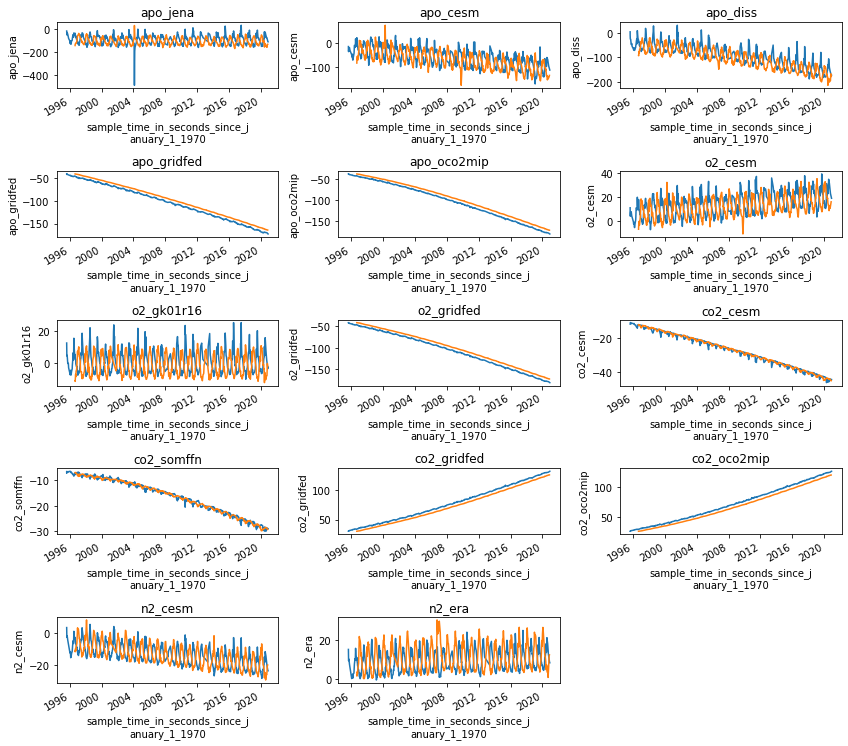

In [21]:
# plot timeseries

sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # including derived vars

station_plot_list=['cba','psa']

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        station_records[stn][v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

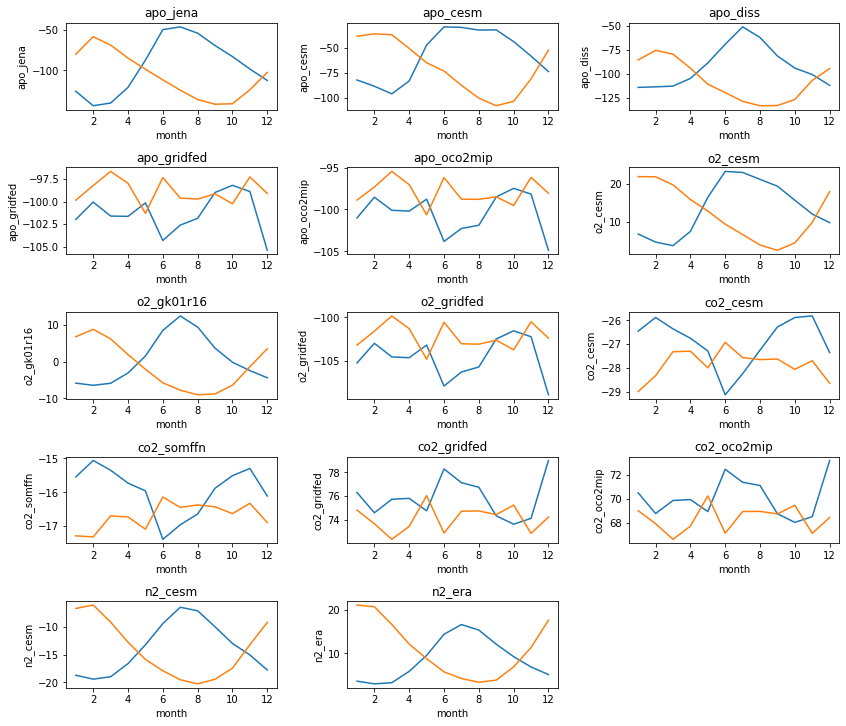

In [22]:
# seasonal climatology

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        ds_seas=station_records[stn][v].groupby('time.month').mean('time')
        ds_seas.plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    